<h2 style='text-align:center'><b>Predicting ANTM Stock Prices</b></h2>
<h5 style="text-align: center;">Ikhza Syafa Muis - JCDS-0410-009</h5>


## Data Understanding

### **Import Library**

In [99]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import warnings

### **Loading Dataset**

In [100]:
# Load the CSV file into a DataFrame
df = pd.read_csv('ANTM.JK.csv')

# Display the DataFrame to check its contents
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,1170.0,1170.0,1105.0,1110.0,956.924927,184669600
1,2019-09-04,1120.0,1140.0,1090.0,1100.0,948.303894,108867300
2,2019-09-05,1105.0,1115.0,1085.0,1100.0,948.303894,109971500
3,2019-09-06,1090.0,1100.0,1075.0,1075.0,926.751587,70609200
4,2019-09-09,1080.0,1135.0,1080.0,1120.0,965.545898,153116500


### Information about the column

| **Column Name** | **Description**                                                                                      |
|-----------------|------------------------------------------------------------------------------------------------------|
| **Date**        | Tanggal transaksi saham                                                                             |
| **Open**        | Harga saham saat pembukaan pasar pada hari tersebut                                                  |
| **High**        | Harga tertinggi yang dicapai saham selama hari perdagangan                                           |
| **Low**         | Harga terendah yang dicapai saham selama hari perdagangan                                            |
| **Close**       | Harga saham saat penutupan pasar pada akhir hari perdagangan                                          |
| **Adj Close**   | Harga penutupan yang disesuaikan dengan dividen dan pemecahan saham                                     |
| **Volume**      | Jumlah saham yang diperdagangkan pada hari tersebut                                                    |


## Preprocessing Data

#### Checking Missing Value

In [101]:
# Checking for missing values
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2)]);

nulldata = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct'],
                     data=listItem)
nulldata

,dataFeatures,dataType,null,nullPct
0,Date,object,0,0.0
1,Open,float64,0,0.0
2,High,float64,0,0.0
3,Low,float64,0,0.0
4,Close,float64,0,0.0
5,Adj Close,float64,0,0.0
6,Volume,int64,0,0.0


Kumpulan data dalam kondisi sangat baik tanpa ada nilai yang hilang di semua kolom. Setiap fitur memiliki data lengkap, yang ideal untuk analisis dan pemodelan.

#### Mengambil kolom 'Date' dan 'Close' dari dataset

In [102]:
data = df[['Date', 'Close']]
data.head()

,Date,Close
0,2019-09-03,1110.0
1,2019-09-04,1100.0
2,2019-09-05,1100.0
3,2019-09-06,1075.0
4,2019-09-09,1120.0


#### Checking data types

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1214 non-null   object 
 1   Close   1214 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


Data yang kami periksa mengandung tipe data yang tidak sesuai. Kolom "Date" seharusnya bertipe data `datetime`, namun saat ini tercatat sebagai `object`. Kami perlu mengonversi kolom ini ke tipe data `datetime` agar analisis waktu dapat dilakukan dengan tepat.

#### Mengubah kolom 'Date' menjadi tipe datetime

In [104]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1214 non-null   datetime64[ns]
 1   Close   1214 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.1 KB


C:\Users\asus\AppData\Local\Temp\ipykernel_10964\511077666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


#### Statistik deskriptif

In [105]:
data.describe()

,Close
count,1214.000000
mean,1715.227348
std,650.940017
min,348.000000
25%,1215.000000
50%,1877.500000
75%,2250.000000
max,3190.000000


Data harga penutupan yang kami analisis mencakup 1214 pengamatan. Rata-rata harga penutupan adalah sekitar 4291.78. Fluktuasi harga di sekitar rata-rata ini biasanya sebesar 859.15, yang menunjukkan variasi harga yang cukup besar. Harga penutupan terendah yang tercatat adalah 1972.69, sementara yang tertinggi mencapai 6400.00. Untuk memberi gambaran lebih jelas, 25% dari harga penutupan berada di bawah 3774.50, sedangkan nilai tengahnya adalah 4290.83, dan 75% harga penutupan berada di bawah 4820.00. Ini menunjukkan bahwa harga seringkali berfluktuasi secara signifikan dengan rentang yang cukup lebar.

#### Normalisasi Data

In [106]:
# Initialize the MinMaxScaler to scale features to the range [0, 1]
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the 'Close' column and transform the data
data_sc = sc.fit_transform(data[['Close']].values)
data_sc

array([[0.26812104],
       [0.26460239],
       [0.26460239],
       ...,
       [0.36664321],
       [0.36840253],
       [0.36312456]])

#### Splitting Data

In [107]:
train_len = math.ceil(len(data_sc) * 0.8)
val_len = math.ceil(train_len * 0.2)
train_len = train_len - val_len
test_len = math.ceil(len(data_sc) *0.2)

In [108]:
train_len, val_len, test_len

(777, 195, 243)

- train_len = 777: Panjang set pelatihan adalah 777 data point. Ini adalah data yang digunakan untuk melatih model.

- val_len = 195: Panjang set validasi adalah 195 data point. Ini adalah data yang digunakan untuk menilai model selama pelatihan dan menyesuaikan hiperparameter.

- test_len = 243: Panjang set pengujian adalah 243 data point. Ini adalah data yang digunakan untuk menguji model setelah pelatihan selesai dan memberikan ukuran akhir kinerja model.

#### Persiapan Data untuk Model LSTM

In [109]:
train_data = data_sc[0:train_len, :]
X_train = []
y_train = []
for i in range(30, len(train_data)):
    X_train.append(train_data[i-30:i,0])
    y_train.append(train_data[i, 0])

In [110]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [111]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [112]:
val_data = data_sc[train_len -30:(train_len+val_len), :]
X_val = []
y_val = []
for i in range(30, len(val_data)):
    X_val.append(val_data[i-30:i, :])
    y_val.append(val_data[i,0])

In [113]:
X_val, y_val = np.array(X_val), np.array(y_val)

In [114]:
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
X_val

array([[[0.59535538],
        [0.57072484],
        [0.56896552],
        ...,
        [0.51442646],
        [0.53377903],
        [0.52146376]],

       [[0.57072484],
        [0.56896552],
        [0.55489092],
        ...,
        [0.53377903],
        [0.52146376],
        [0.55137227]],

       [[0.56896552],
        [0.55489092],
        [0.5531316 ],
        ...,
        [0.52146376],
        [0.55137227],
        [0.58128079]],

       ...,

       [[0.57776214],
        [0.57776214],
        [0.58128079],
        ...,
        [0.56192822],
        [0.56544687],
        [0.57952146]],

       [[0.57776214],
        [0.58128079],
        [0.57776214],
        ...,
        [0.56544687],
        [0.57952146],
        [0.57776214]],

       [[0.58128079],
        [0.57776214],
        [0.57776214],
        ...,
        [0.57952146],
        [0.57776214],
        [0.57952146]]])

#### Membuat Model LSTM

In [115]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dense(units=1))

c:\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [116]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping Callback
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    verbose=1,
    restore_best_weights=True
)

# ModelCheckpoint Callback
checkpoint_path = 'model_checkpoints/weight_lstm_model.weights.h5'  # Ubah ekstensi ke .weights.h5
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,  # Pastikan ini True jika hanya menyimpan bobot
    verbose=1
)


In [117]:
op = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=op, loss='mean_squared_error')

In [118]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])
history

Epoch 1/100
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1770
Epoch 1: val_loss improved from inf to 0.00149, saving model to model_checkpoints/weight_lstm_model.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.1731 - val_loss: 0.0015
Epoch 2/100
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102
Epoch 2: val_loss improved from 0.00149 to 0.00141, saving model to model_checkpoints/weight_lstm_model.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0102 - val_loss: 0.0014
Epoch 3/100
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0086
Epoch 3: val_loss improved from 0.00141 to 0.00138, saving model to model_checkpoints/weight_lstm_model.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 4/100
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0076
Epoch 4: val_loss did not improve from 0.00138
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 5/100
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/s

#### Evaluasi Model Selama Training

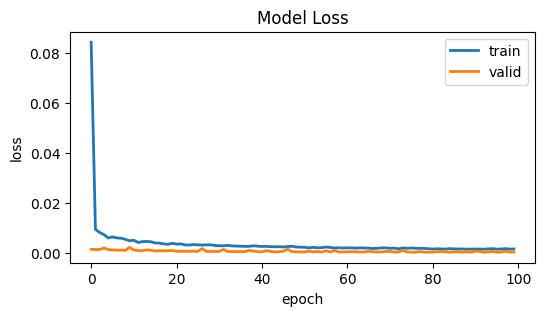

In [119]:
plt.figure(figsize=(6,3))
plt.title('Model Loss')
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

Insight:

Grafik yang ditampilkan menunjukkan tren penurunan model loss selama proses pelatihan model pembelajaran mesin, dengan dua garis yang mewakili train loss dan valid loss. Pada awal pelatihan, train loss dimulai dengan nilai yang cukup tinggi, sekitar 0,05, namun dengan cepat menurun drastis setelah beberapa epoch pertama. Setelah sekitar 20 epoch, train loss stabil dan terus menurun perlahan menuju nol. Di sisi lain, valid loss dimulai dari nilai yang lebih rendah dibandingkan train loss dan tetap relatif stabil sepanjang pelatihan, dengan sedikit fluktuasi, bergerak mendekati nol dengan kecepatan yang lebih lambat. Penurunan loss yang konsisten pada kedua garis menunjukkan bahwa model secara efektif meminimalkan kesalahan baik pada data pelatihan maupun data validasi. Stabilitas valid loss mengindikasikan bahwa model tidak mengalami overfitting yang signifikan, karena performanya pada data validasi tetap konsisten. Perbedaan yang kecil antara train loss dan valid loss menunjukkan bahwa model memiliki kemampuan generalisasi yang baik terhadap data baru. Secara keseluruhan, grafik ini mengindikasikan bahwa model belajar dengan baik dan mempertahankan performa yang memadai pada data validasi.

In [120]:
test_data = data_sc[(-test_len - 30): , : ]
x_test = []
y_test = data[['Close']].iloc[-test_len : , :].values
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i,0])

test_data


array([[0.58128079],
       [0.57776214],
       [0.57776214],
       [0.57776214],
       [0.57248417],
       [0.57248417],
       [0.57248417],
       [0.57600281],
       [0.57072484],
       [0.56720619],
       [0.57600281],
       [0.59535538],
       [0.58479944],
       [0.58479944],
       [0.58831809],
       [0.59535538],
       [0.58479944],
       [0.58479944],
       [0.57776214],
       [0.57776214],
       [0.58128079],
       [0.57776214],
       [0.56720619],
       [0.56368754],
       [0.56368754],
       [0.56192822],
       [0.56544687],
       [0.57952146],
       [0.57776214],
       [0.57952146],
       [0.57952146],
       [0.57952146],
       [0.57776214],
       [0.56544687],
       [0.56368754],
       [0.56368754],
       [0.56192822],
       [0.56544687],
       [0.56192822],
       [0.56544687],
       [0.56192822],
       [0.55137227],
       [0.5460943 ],
       [0.5460943 ],
       [0.52674173],
       [0.52498241],
       [0.5320197 ],
       [0.523

In [121]:
x_test = np.array(x_test)
x_test

array([[0.58128079, 0.57776214, 0.57776214, ..., 0.57952146, 0.57776214,
        0.57952146],
       [0.57776214, 0.57776214, 0.57776214, ..., 0.57776214, 0.57952146,
        0.57952146],
       [0.57776214, 0.57776214, 0.57248417, ..., 0.57952146, 0.57952146,
        0.57952146],
       ...,
       [0.35256861, 0.34904996, 0.34025334, ..., 0.3947924 , 0.3877551 ,
        0.37368051],
       [0.34904996, 0.34025334, 0.33849402, ..., 0.3877551 , 0.37368051,
        0.36664321],
       [0.34025334, 0.33849402, 0.32793807, ..., 0.37368051, 0.36664321,
        0.36840253]])

In [122]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test

array([[[0.58128079],
        [0.57776214],
        [0.57776214],
        ...,
        [0.57952146],
        [0.57776214],
        [0.57952146]],

       [[0.57776214],
        [0.57776214],
        [0.57776214],
        ...,
        [0.57776214],
        [0.57952146],
        [0.57952146]],

       [[0.57776214],
        [0.57776214],
        [0.57248417],
        ...,
        [0.57952146],
        [0.57952146],
        [0.57952146]],

       ...,

       [[0.35256861],
        [0.34904996],
        [0.34025334],
        ...,
        [0.3947924 ],
        [0.3877551 ],
        [0.37368051]],

       [[0.34904996],
        [0.34025334],
        [0.33849402],
        ...,
        [0.3877551 ],
        [0.37368051],
        [0.36664321]],

       [[0.34025334],
        [0.33849402],
        [0.32793807],
        ...,
        [0.37368051],
        [0.36664321],
        [0.36840253]]])

In [123]:
model.load_weights("model_checkpoints/weight_lstm_model.weights.h5")

In [124]:
y_pred = model.predict(x_test)
y_pred = np.ceil(sc.inverse_transform(y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


#### Evaluasi Akhir Model

- **RMSE**

Root Mean Squared Error (RMSE) adalah ukuran yang digunakan untuk menilai seberapa baik model memprediksi nilai target dengan mengukur rata-rata dari akar kuadrat perbedaan antara nilai prediksi model dan nilai aktual. RMSE memberikan gambaran tentang seberapa besar kesalahan prediksi model, tetapi dalam unit yang sama dengan nilai target, membuatnya lebih mudah diinterpretasikan dibandingkan dengan Mean Squared Error (MSE).

Rumus dari RMSE:

</b>
<img src="https://editor.analyticsvidhya.com/uploads/56967RMSE.png" alt="RMSE" width="300"/>


In [125]:
rmse = np.sqrt(np.mean(((y_test - y_pred)**2)))
rmse

63.55380727976166

Nilai Root Mean Squared Error (RMSE) yang dihitung adalah 63.55 rupiah. RMSE ini menunjukkan rata-rata kesalahan prediksi model dalam unit yang sama dengan nilai target. RMSE yang lebih rendah menunjukkan model yang lebih akurat, sedangkan RMSE yang lebih tinggi menunjukkan bahwa kesalahan prediksi model lebih besar.

- **MAE**

Mean Absolute Error (MAE) adalah metrik yang digunakan untuk mengevaluasi seberapa baik model memprediksi nilai target dengan mengukur rata-rata selisih absolut antara nilai prediksi model dan nilai aktual. MAE memberikan gambaran tentang seberapa besar kesalahan prediksi model tanpa memperbesar perbedaan dengan kuadrat, sehingga lebih mudah diinterpretasikan dalam konteks yang sama dengan data target.

Rumus dari MAE:

</b>
<img src="https://editor.analyticsvidhya.com/uploads/42439Screenshot%202021-10-26%20at%209.34.08%20PM.png" alt="MAE" width="300"/>


In [126]:
mae = mean_absolute_error(y_test, y_pred)
mae

52.041152263374485

Secara keseluruhan, MAE sebesar 52.04 menunjukkan bahwa model memiliki rata-rata kesalahan prediksi sekitar 52.04 rupiah. Ini adalah ukuran yang berguna untuk mengevaluasi akurasi model dengan cara yang mudah dipahami dan tidak terlalu dipengaruhi oleh kesalahan yang sangat besar.

- **MAPE**

 MAPE mengukur rata-rata dari selisih absolut antara nilai aktual dan nilai prediksi dalam bentuk persentase dari nilai aktual. Ini memungkinkan untuk menilai kesalahan dalam konteks relatif, yaitu seberapa besar kesalahan prediksi dibandingkan dengan nilai aktual.

Rumus MAPE:

</b>
<img src="https://1.bp.blogspot.com/-0995oy9kwNo/Xfh7nJ9tL_I/AAAAAAAABbY/yMXNlUJqzRw5fqWTyYZYGsk9SOpEIWMCwCLcBGAsYHQ/s1600/MAAAA.JPG" alt="MAPE" width="300"/>


In [127]:
mape = (mean_absolute_percentage_error(y_test, y_pred)*100)
mape

3.376271441593423

Dengan MAPE sebesar 3.37%, ini berarti rata-rata kesalahan prediksi model adalah sekitar 3.37% dari nilai aktual. Nilai ini menunjukkan bahwa prediksi model memiliki rata-rata kesalahan yang relatif kecil jika dibandingkan dengan nilai aktual, dan model Anda cukup akurat dalam konteks persentase kesalahan.

#### Hasil Prediksi

In [128]:
data_pred = data[-test_len:].copy()
data_pred['Prediction'] = y_pred
data_pred

,Date,Close,Prediction
971,2023-08-29,1995.0,1993.0
972,2023-08-30,1995.0,2004.0
973,2023-08-31,1990.0,2012.0
974,2023-09-01,1955.0,2016.0
975,2023-09-04,1950.0,2011.0
...,...,...,...
1209,2024-08-28,1450.0,1520.0
1210,2024-08-29,1410.0,1515.0
1211,2024-08-30,1390.0,1499.0
1212,2024-09-02,1395.0,1477.0


### Visualisasi Hasil Prediksi

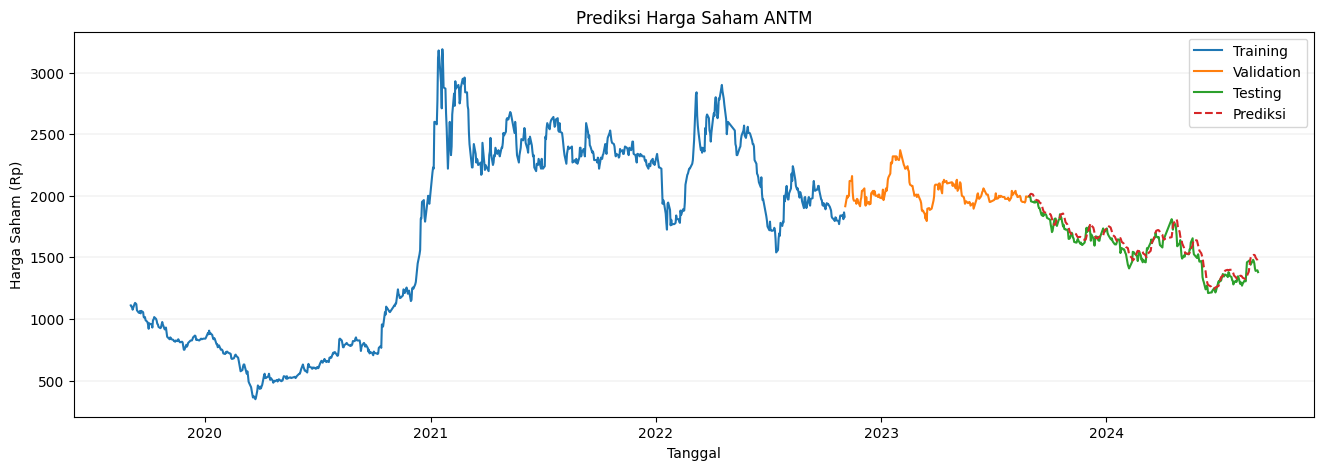

In [129]:
train = data[:train_len]
valid = data[train_len:(train_len + val_len)]

plt.figure(figsize=(16,5))
plt.title('Prediksi Harga Saham ANTM')
plt.plot(train['Date'], train['Close'], label='Training')
plt.plot(valid['Date'], valid['Close'], label='Validation')
plt.plot(data_pred['Date'], data_pred['Close'], label='Testing')
plt.plot(data_pred['Date'], data_pred['Prediction'], label='Prediksi', linestyle='--')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (Rp)')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

Gambar tersebut menunjukkan prediksi harga saham ANTM menggunakan model yang dilatih dengan data yang dibagi menjadi tiga bagian: training, validation, dan testing. Data training (garis biru) meliputi 2019 hingga pertengahan 2022, validation (garis oranye) dari pertengahan 2022 hingga 2023, dan testing (garis hijau) dari 2023 hingga pertengahan 2024. Garis merah putus-putus menunjukkan prediksi model. Secara keseluruhan, model ini berhasil mengikuti tren harga saham dengan baik, terutama pada data testing, meskipun ada beberapa deviasi pada periode dengan volatilitas tinggi.

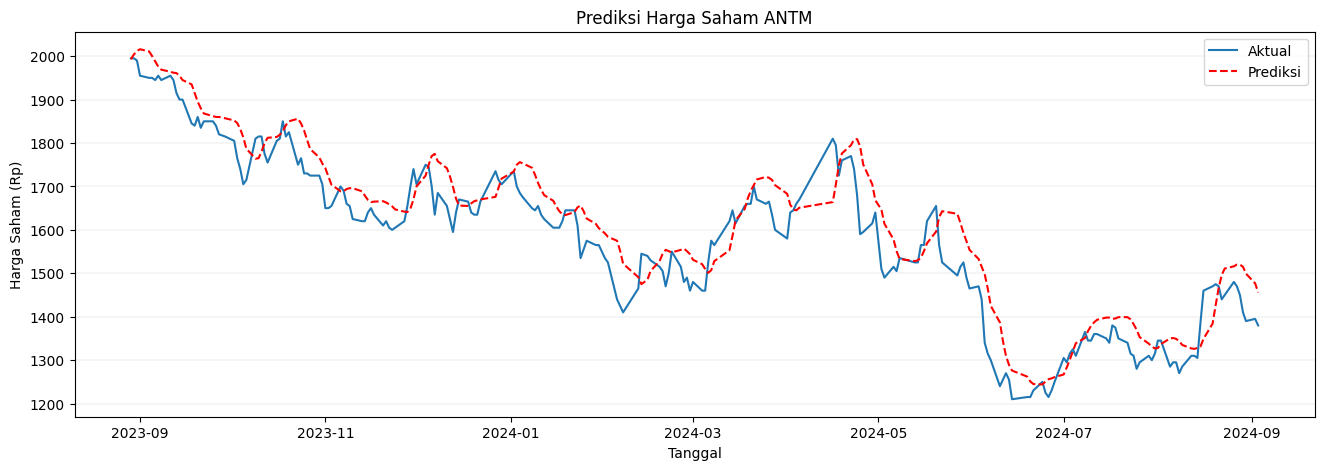

In [130]:
plt.figure(figsize=(16,5))
plt.title('Prediksi Harga Saham ANTM')
plt.plot(data_pred['Date'], data_pred['Close'], label='Aktual')
plt.plot(data_pred['Date'], data_pred['Prediction'], label='Prediksi', color='red', linestyle='--')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (Rp)')
plt.legend()
plt.grid(True, linewidth=0.18, axis='y')
plt.show()

Gambar diatas merupakan perbesaran (zoom-in) dari bagian data testing dan prediksi yang terdapat dalam gambar kedua. Pada gambar tersebut, fokusnya adalah pada perbandingan antara harga saham aktual dan hasil prediksi model LSTM untuk periode testing, yang mencakup tahun 2023 hingga 2024. Garis biru menunjukkan harga saham aktual, sementara garis merah putus-putus menunjukkan hasil prediksi model. Perbesaran ini memperlihatkan lebih detail bagaimana model prediksi mengikuti pergerakan harga saham pada periode testing, memberikan gambaran yang lebih jelas tentang kinerja model dalam memprediksi harga saham selama periode tersebut.

### Tantangan dan Pertimbangan Lanjutan

Meskipun model LSTM menunjukkan hasil yang menjanjikan dalam memprediksi harga saham ANTM, ada beberapa tantangan dan pertimbangan yang perlu diperhatikan:

- **Volatilitas Pasar:** Harga saham sangat dipengaruhi oleh banyak faktor eksternal seperti berita ekonomi, kebijakan pemerintah, dan kejadian tak terduga lainnya. Model LSTM, meskipun kuat dalam menangkap pola waktu yang ada, mungkin tidak selalu mampu memprediksi perubahan mendadak yang disebabkan oleh kejadian tak terduga.

- **Ketergantungan pada Data Historis:** Model LSTM bergantung pada data historis untuk membuat prediksi. Jika terdapat perubahan mendasar dalam pasar atau dalam perusahaan yang tidak tercermin dalam data historis, model mungkin tidak mampu menyesuaikan prediksinya dengan kondisi baru ini.

- **Data Eksternal:** Menambahkan fitur lain seperti sentimen pasar, data ekonomi makro, dan indikator teknis lainnya bisa meningkatkan akurasi model. Namun, ini juga meningkatkan kompleksitas model dan membutuhkan pra-pemrosesan data yang lebih intensif. Selain itu, integrasi data eksternal ini perlu dilakukan dengan hati-hati untuk menghindari kebisingan yang dapat mengurangi kinerja model.


### Kesimpulan

Prediksi harga saham menggunakan model LSTM menawarkan potensi yang besar dalam analisis keuangan. Dalam studi ini, model LSTM telah menunjukkan kinerjanya yang cukup baik dalam memprediksi harga saham ANTM, dengan kesalahan prediksi yang relatif rendah. Hasil ini menunjukkan bahwa model LSTM mampu menangkap pola-pola penting dalam data harga saham dan dapat digunakan sebagai alat bantu dalam pengambilan keputusan investasi.

Namun, penting untuk diingat bahwa meskipun model ini menunjukkan hasil yang menjanjikan, prediksi harga saham selalu melibatkan tingkat ketidakpastian yang tinggi. Faktor-faktor eksternal yang tidak dapat diprediksi oleh model tetap memiliki peran besar dalam pergerakan harga saham. Oleh karena itu, hasil prediksi dari model ini sebaiknya digunakan sebagai salah satu alat dalam analisis investasi, bukan sebagai satu-satunya penentu keputusan.

Di masa depan, peningkatan lebih lanjut dapat dilakukan dengan menggabungkan data eksternal, memperbarui model secara berkala dengan data terbaru, dan menerapkan teknik pemrosesan data yang lebih canggih. Dengan demikian, model LSTM dapat menjadi alat yang semakin kuat dan akurat dalam dunia investasi keuangan.
